#### <b>필요한 라이브러리 불러오기</b>

* 실습을 위해 필요한 라이브러리를 불러옵니다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda")

#### <b>학습 데이터 생성</b>

* <b>사인(Sine) 함수</b>를 이용해 데이터를 생성합니다.

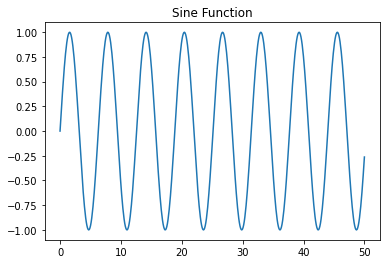

In [ ]:
data_size = 500

data_x = np.linspace(0, 50, data_size) # 0부터 50까지 500개의 포인트 설정
data_y = np.sin(data_x) # 각 포인트에 대한 sine() 값 계산

plt.title("Sine Function")
plt.plot(data_x, data_y)
plt.show()

* 사인(Sine) 함수의 값을 이용해 학습용 데이터셋을 생성합니다.

In [ ]:
sequence_size = 10
train_size = data_size - sequence_size

train_X = []
train_Y = []

for i in range(0, train_size):
    train_X.append(data_y[i:i + sequence_size]) # 앞의 10개가 주어졌을 때
    train_Y.append(data_y[i + sequence_size]) # 다음 값을 맞추는 문제

train_X = np.array(train_X)
train_Y = np.array(train_Y)

# [시퀀스의 개수, 시퀀스 크기]
print(train_X.shape)
print(train_Y.shape)

train_X = torch.from_numpy(train_X)
train_Y = torch.from_numpy(train_Y)

# PyTorch에서 사용할 수 있는 형태로 변환 후에 GPU로 옮기기
train_X = torch.transpose(train_X, 0, 1).unsqueeze(2).float().to(device)
train_Y = train_Y.unsqueeze(1).float().to(device)

print(train_X.shape) # [시퀀스 크기, 시퀀스 개수, 1]
print(train_Y.shape)

(490, 10)
(490,)
torch.Size([10, 490, 1])
torch.Size([490, 1])


#### <b>LSTM 모델 정의하기</b>

* 하이퍼 파라미터를 설정합니다.
* LSTM 모델을 정의합니다.

In [ ]:
input_dim = 1
output_dim = 1
hidden_dim = 1000

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(LSTM, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim)
        self.w_hy = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x, h, c):
        # x: [seq_len, batch, input_size], h: [num_layers, batch, hidden_size], c: [num_layers, batch, hidden_size]
        outputs, (hidden, cell) = self.lstm(x, (h, c))
        # PyTorch의 LSTM의 outputs은 모든 결과를 가지고 있으며 hidden과 cell은 마지막 context vector를 의미
        # 현재 예제에서는 context vector를 사용하지 않음 (기계 번역 등에서는 사용)
        y = self.w_hy(outputs[-1].unsqueeze(0)) # 하나의 결과를 찾는 회귀(regression) 문제이므로 마지막 원소를 확인
        return y, outputs

#### <b>LSTM 모델 학습하기</b>

* LSTM 모델을 학습합니다.

In [ ]:
# 현재 모델의 출력을 확인
def show(lstm):
    lstm.eval()
    predictions = []

    # 현재 예제에서는 [레이어 수 = 1, 학습 데이터의 개수 = 배치 크기, 히든 크기]
    h = torch.zeros(1, train_size, hidden_dim).to(device)
    c = torch.zeros(1, train_size, hidden_dim).to(device)

    # 전체 시퀀스 데이터를 한꺼번에 넣기
    y_pred, h = lstm(train_X, h, c)

    plt.title("Prediction Result")
    plt.plot(data_x[sequence_size:], data_y[sequence_size:])
    plt.plot(data_x[sequence_size:], y_pred.view(-1).cpu().detach().numpy())
    plt.legend(["Real", "Predicted"])
    plt.show()

[ Training Start ]


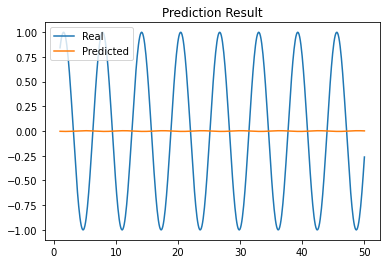

[1000/10000] loss = 5.114426130603533e-06


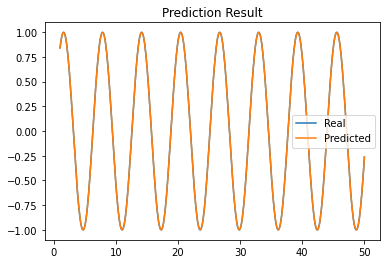

[2000/10000] loss = 1.1269404467384447e-06


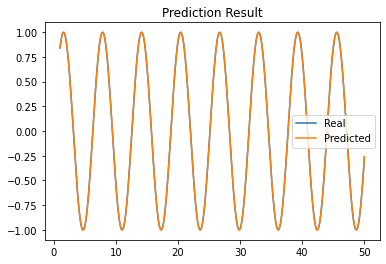

[3000/10000] loss = 1.0940743777609896e-06


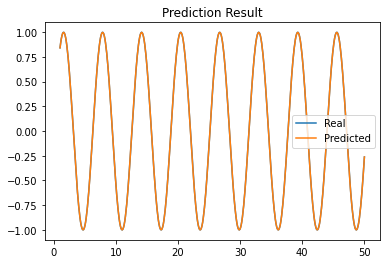

[4000/10000] loss = 1.0674566510715522e-06


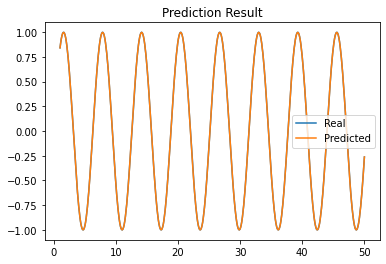

[5000/10000] loss = 1.0457805501573603e-06


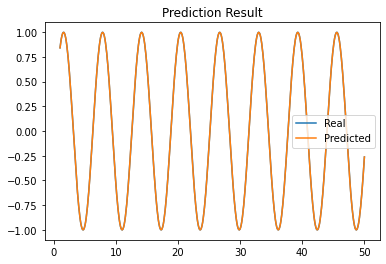

[6000/10000] loss = 1.0280815558871836e-06


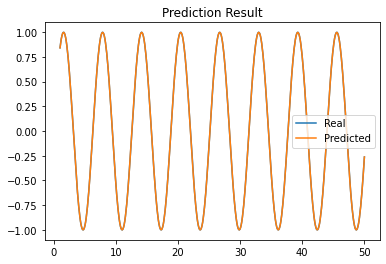

[7000/10000] loss = 1.0135366892427555e-06


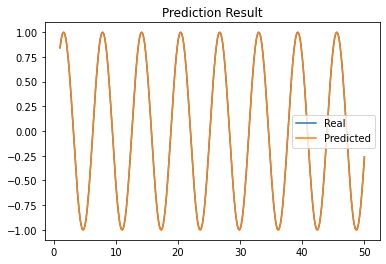

[8000/10000] loss = 1.0015397720053443e-06


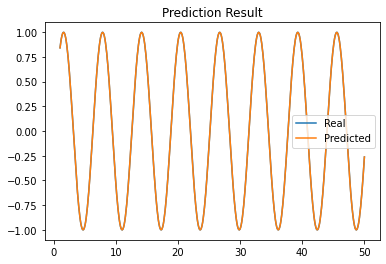

[9000/10000] loss = 9.915480632116669e-07


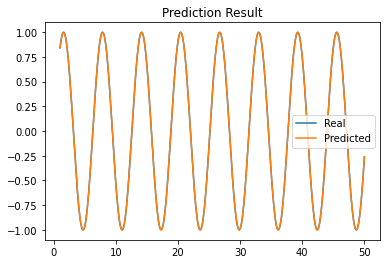

[10000/10000] loss = 9.83185600489378e-07


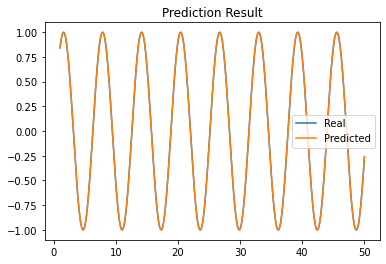

In [ ]:
lstm = LSTM(input_dim, output_dim, hidden_dim).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.01, momentum=0.9)

print("[ Training Start ]")
show(lstm)

epoch = 10000

for i in range(epoch):
    lstm.train()
    lstm.zero_grad()
    optimizer.zero_grad()

    # 현재 예제에서는 [레이어 수 = 1, 학습 데이터의 개수 = 배치 크기, 히든 크기]
    h = torch.zeros(1, train_size, hidden_dim).to(device)
    c = torch.zeros(1, train_size, hidden_dim).to(device)

    # 전체 시퀀스 데이터를 한꺼번에 넣기
    y_pred, h = lstm(train_X, h, c)

    # 손실(loss) 값을 계산하여 학습 진행
    loss = loss_fn(train_Y, y_pred.squeeze(0))
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 1000 == 0:
        print(f"[{i + 1}/{epoch}] loss = {loss.item()}")
        show(lstm)

#### <b>자동으로 결과 예측해 보기</b>

* 초반의 데이터만 입력한 상태에서 앞으로의 모든 결과를 예측해 봅시다.

In [ ]:
# 평가를 위한 하나의 시퀀스 생성
test_X = train_X[:, 0, :].unsqueeze(2)
print(test_X.shape)

lstm.eval()
predictions = []

for i in range(1000):
    # 현재 예제에서는 [레이어 수 = 1, 평가 데이터의 개수 = 배치 크기, 히든 크기]
    h = torch.zeros(1, 1, hidden_dim).to(device)
    c = torch.zeros(1, 1, hidden_dim).to(device)

    # 전체 시퀀스 데이터를 한꺼번에 넣기
    y_pred, h = lstm(test_X, h, c)

    test_X = torch.cat((test_X, y_pred), dim=0)[1:]
    predictions.append(y_pred.item())

torch.Size([10, 1, 1])


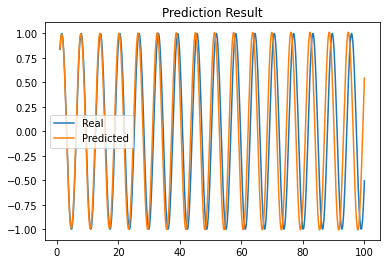

In [ ]:
test_x = np.linspace(0, 100, 1000 + sequence_size)
test_y = np.sin(test_x) # 각 포인트에 대한 sine() 값 계산

plt.title("Prediction Result")
plt.plot(test_x[sequence_size:], test_y[sequence_size:])
plt.plot(test_x[sequence_size:], predictions)
plt.legend(["Real", "Predicted"])
plt.show()